# Initial setups

In [1]:
using JuMP
using Gurobi
env = Gurobi.Env()
using PowerSystems

using Graphs
using MetaGraphsNext
using CairoMakie
using GraphMakie
using SparseArrays
using GraphMakie.NetworkLayout

CairoMakie.activate!(type = "svg")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27


In [2]:
mutable struct Branch
    b::Float64
    p_max::Float64
    v_nom1::Float64
    v_nom2::Float64
    p::Float64
    outage::Bool
    trip::Bool
    Branch(b, p_max) = new(b, p_max, 0, 0, 0, false, false)
    Branch(b, p_max, v_nom1, v_nom2) = new(b, p_max, v_nom1, v_nom2, 0, false, false)
    Branch(b::Branch) = new(b.b, b.p_max, b.v_nom1, b.v_nom2, b.p, false, false)
    Branch(b::Branch, p_max) = new(b.b, p_max, b.v_nom1, b.v_nom2, b.p, false, false)
end

struct BranchId
    bus1::Int64
    bus2::Int64
end

In [3]:
mutable struct SubBus
    p::Float64
    branch_ids::Vector{Int8}
end

mutable struct BusConf
    bus::Int16
    subBuses::Vector{SubBus}
end

## Utility functions

## Graph

In [ ]:
e_index_for(g::MetaGraph, e::Graphs.SimpleEdge) = g[label_for(g,src(e)), label_for(g,dst(e))]

e_index_for (generic function with 1 method)

In [372]:
function add_subBus(g::MetaGraph, busconfs::Vector{BusConf})
    h=deepcopy(g)
    e_labels = collect(edge_labels(h))
    for bc in busconfs
        bc_bus_label = label_for(g, bc.bus)
        # Map the branches of the subBus
        sb2edges = Dict(sb => [e_labels[br] for br in sb.branch_ids] for sb in bc.subBuses)

        # removes the bus
        rem_vertex!(h, code_for(h, bc_bus_label))

        # Build the new bus and connect the branches
        for (i, sb) in enumerate(bc.subBuses)
            #create the new vertex
            new_v_label = "$(bc_bus_label)-$i"
            h[new_v_label] = sb.p
            # connect the copy of the branches
            for br in sb2edges[sb]
                new_e_label = br[1] == bc_bus_label ? (new_v_label, br[2]) : (br[1], new_v_label)
                h[new_e_label...] = g[br...]
            end
        end
    end
    h
end

add_subBus (generic function with 2 methods)

### Parse MatPower files

In [6]:
function network2graph(sys::System)
    g = MetaGraph(
        DiGraph();
        label_type=String,
        vertex_data_type = Float64,
        edge_data_type = Branch,
    )

    init_p_bus(p_bus, sys, objType, op) = 
        for k in get_components(objType, sys)
            g["$(k.bus.number)"] = op(haskey(g,"$(k.bus.number)") ? g["$(k.bus.number)"] : 0, k.active_power)
        end
    init_p_bus(g, sys, PowerLoad, +)
    init_p_bus(g, sys, Generator, -)
    
    for k in get_components(ACBranch, sys)
        g["$(k.arc.from.number)", "$(k.arc.to.number)"] = Branch(1/k.x, 10, k.arc.from.base_voltage, k.arc.to.base_voltage)
    end
    
    to_remove = []
    for v in vertices(g)
        if isempty(inneighbors(g,v)) && isempty(outneighbors(g,v))
            push!(to_remove, label_for(g,v))
        end
    end
    foreach(v-> rem_vertex!(g, code_for(g,v)), to_remove)
    
    g
end

network2graph (generic function with 1 method)

### Tune the grid with constraints - indicators on OTS results

In [246]:
add_constraint(g, fun) = foreach(e -> fun(e_index_for(g,e)), edges(g))

set_limitations(branches, lim) = Dict( k => begin
        br_out = Branch(br_in, br_in.v_nom1 == 138.0 ? lim : 10)
    end for (k,br_in) in branches)

function indicators(model)
    sw = [s for s in model[:sw] if value(s) == 0.0]
    ls = [l for l in model[:ls] if value(l) ≠ 0.0]
    sw, ls
end

indicators (generic function with 1 method)

In [ ]:
function check_flow_consistency(g; v::Bool=false)
    flows = Dict(l => g[l...].p for l in edge_labels(g))
    injections = Dict(l => g[l] for l in labels(g))

    # Initialize net flows for each node
    net_flows = Dict{String, Float64}()

    # Update net flows based on branch flows
    for ((from, to), flow) in flows
        net_flows[from] = get(net_flows, from, 0.0) - flow
        net_flows[to] = get(net_flows, to, 0.0) + flow
    end

    # Compare with injections
    consistent = true

    v && println("\nComparison with injections:")
    for (node, injection) in injections
        net_flow = get(net_flows, node, 0.0)

        v && println("Node $node: Injection = $injection, Net Flow = $net_flow, Difference = $(injection - net_flow)")
        if abs(injection - net_flow) > 1e-9  # Tolerance for floating-point comparison
            consistent = false
        end
    end

    if v
        if consistent
            println("\nThe flows and injections are consistent.")
        else
            println("\nThe flows and injections are not consistent.")
        end
    end
    consistent
end

check_flow_consistency (generic function with 1 method)

## Drawing

In [198]:
function edge_coloring(g, e)
    branch = e_index_for(g, e)
    if branch.outage
        return :black
    elseif abs(branch.p>branch.p_max)
        return :red
    else
        return :green
    end
end

function edge_style(g, e)
   return e_index_for(g,e).trip ? :dot : :solid 
end

function draw(g_orig::MetaGraph; outages = [], trip = nothing, edge_coloring = edge_coloring, edge_style = edge_style, fig_size = (900, 600), font_size = 26, digits = 2)
    g = copy(g_orig)
    e_labels = edge_labels(g)
    MaxP = maximum(collect(labels(g)) .|> l->abs(g[l]))
    gLabels = [label_for(g, v) for v in vertices(g)]
    to_reverse = []
    for (i,e) in enumerate(edges(g))
        br = e_index_for(g, e)
        if i in outages
            br.outage = true
        end
        if i == trip
            br.trip = true
        end
        if br.p<0
            push!(to_reverse, e)
        end
    end
    for e in to_reverse
        b = e_index_for(g, e)
        b.p = -b.p
        rem_edge!(g, src(e), dst(e))
        g[label_for(g,dst(e)), label_for(g,src(e))] = b
    end

    fig = Figure(size = fig_size, fontsize = font_size)
    ax = Axis(fig[1, 1])
    graphplot!(ax, g;
        # layout = Spring(C=3),
        layout = Stress(Ptype=Float32),
    # nlabels = ["$l" for l in gLabels],
        nlabels = ["$l($(round(g[l], digits=digits)))" for l in gLabels],
        node_size = [sqrt(abs(g[l]))/sqrt(MaxP)*80 for l in gLabels],
        node_attr = (marker = [g[l]>=0 ? :rect : :circle for l in gLabels], color= :white, strokecolor = :red, strokewidth = 3,),
        elabels = [repr(round(e_index_for(g, e).p, digits=digits)) for e in edges(g)],
		edge_attr = (linestyle = [edge_style(g,e) for e in edges(g)],),
        edge_plottype=:beziersegments,
        edge_color = [edge_coloring(g,e) for e in edges(g)],
        edge_width = 5,
        arrow_size = 25,
        arrow_shift = :end,
        )
    hidedecorations!(ax)
    hidespines!(ax)

    ax.aspect = DataAspect()
    display(fig)
    fig
end

draw (generic function with 1 method)

# Models

## DC-PF with linear algebra

In [345]:
function dc_flow!(g; outages = [], trip = nothing)
    A = incidence_matrix(g; oriented = true)'
    for outage in outages
        A[outage,:] .= 0
    end
    if trip ≠ nothing
        A[trip,:] .= 0
    end
    D = spdiagm([e_index_for(g,e).b for e in edges(g)])
    B = A'*D*A
    # B_inv = inv(Matrix(B + spdiagm(fill(1/nv(g), nv(g)))))
    B_inv = inv(Matrix(B + fill(1/nv(g), nv(g), nv(g))))
    # B_inv = inv(Matrix(B))
    # display(B_inv)
    p_to_f = D*A*B_inv
    flows = p_to_f * [g[label_for(g, v)] for v in vertices(g)]
    for (i,e) in enumerate(edges(g))
        e_index_for(g, e).p = flows[i]
    end
end

dc_flow! (generic function with 1 method)

## Secured DC PF

$$ \rho^* = {\arg\,\min_{\rho, \vec{f}}}\, \rho\\
s.t.\\
\vec{f} = \mathbf{DA\hat{B}^{-1}} \vec{p}\\
|\vec{f}| \preceq \rho \overline{\vec{f}}$$

$$ \rho^* = \arg\,\min_{\rho, \vec{f}}\,\max_{\vec{\beta},\vec{u}}\, \rho\\
s.t.\\
\vec{f_i} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})\vec{\beta}\\
|\vec{f}| \preceq \rho \overline{\vec{f}}$$

ie with $ dim(\vec{u}) = dim(\vec{\beta}) = dim(\vec{\alpha})$
$$ \rho^* = \arg\,\min_{\rho}\, \rho \\
s.t. \\
\vec{F_i} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})\vec{\beta_i} \ \forall i\\
\rho \ge \alpha_i \ \forall i\\
|\vec{F_i}| \preceq \alpha_i \overline{\vec{f}} \ \forall i \\
0 \preceq \vec{\alpha} \preceq \vec{u}M \\
|\vec{f}| \preceq (1-\vec{u})M \\
|\vec{\beta}| \preceq \vec{u}M \\
u_l \in \{0,1\} \\
\sum_l{u_l} \le 1
$$


In [ ]:
function create_dc_matrix(g)
    A = incidence_matrix(g; oriented = true)'
    D = spdiagm([e_index_for(g,e).b for e in edges(g)])
    B = A'*D*A
    B_inv = inv(Matrix(B + spdiagm(fill(1/nv(g), nv(g)))))
    p_to_f = D*A*B_inv
    δ_to_f = D - p_to_f*A'*D
    A, D, B_inv, p_to_f, δ_to_f
end

create_dc_matrix (generic function with 1 method)

In [ ]:
function secured_dc_pf_optim(g, contingencies)
    model = direct_model(Gurobi.Optimizer())
    set_silent(model)

    A, D, B_inv, p_to_f, δ_to_f = create_dc_matrix(g)

    big_M = 100

    p = [g[label_for(g, v)] for v in vertices(g)]
    p_max = [e_index_for(g, e).p_max for e in edges(g)]
    
    outages = collect(contingencies)
    push!(outages, 0)
    nb_c = length(outages)

    @variable(model, β[1:nb_c, 1:ne(g)])
    @constraint(model, [i=1:nb_c],  β[i,:] .≤ [j==outages[i] ? big_M : 0 for j in 1:ne(g)])
    @constraint(model, [i=1:nb_c], -β[i,:] .≤ [j==outages[i] ? big_M : 0 for j in 1:ne(g)])

    @variable(model, flows[1:nb_c, 1:ne(g)])
    @constraint(model, [i=1:nb_c], flows[i,:] .== p_to_f * p + δ_to_f * β[i,:])
    @constraint(model, [i=1:nb_c-1], flows[i, outages[i]] == 0) # i=nb_c : base case
    
    @variable(model, α[1:nb_c])
    @constraint(model, [i=1:nb_c], flows[i,:] .≤ α[i].*p_max)
    @constraint(model, [i=1:nb_c], -α[i].*p_max .≤ flows[i,:])

    @variable(model, α_max)
    @constraint(model, [i=1:nb_c], α .≤ α_max)

    @objective(model, Min, α_max)
    model
end

secured_dc_pf_optim (generic function with 1 method)

In [ ]:
model = secured_dc_pf_optim(g, [1])
optimize!(model)
println(value.(model[:α]))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27
[1.5670927843557863, 1.541072694745593]


## Secured DC OTS

With $\mathcal{C}$ the set of contingencies, $\mathcal{V}$ the set of edges and $\mathcal{E}$ the set of edges.

$$
\begin{split}
    \rho^* = \arg\,\min_{\pmb{\gamma},\vec{v}, \pmb{\beta}, \pmb{f}, \rho}\, & \rho +\alpha \sum_{e \in \mathcal{E}}{v_e}\\
    s.t.\\
    \vec{f_c} = \pmb{DA\hat{B}^{-1}} \vec{p} + (\pmb{D - DA\hat{B}^{-1}A^TD})(\vec{\beta_c} + \vec{\gamma_c}) & \quad \forall c \in \mathcal{C} \\
    |\vec{f_c}| \preceq \rho \overline{\vec{f_c}} & \quad \forall c \in \mathcal{C} \\
    (1-\vec{v}) \odot \vec{\gamma_c} = 0 & \quad \forall c \in \mathcal{C} \\
    \beta_{c, e} = 0 & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E}\ |\ c\ne e \\
    v_{e} \in \{0,1\} & \quad \forall e \in \mathcal{E} \\
\end{split}
$$

The cost function is the weighted sum of the maximum overload and the sum of line openings. The later term reduces the number of line openings, the weight $\alpha$ can be pretty low so that it does not impede the main cost.

A lower bound can be set on the overload so that $\rho \ge \rho\_min\_bound$ (the default value is 0). Thus, when a line is below this bound, no measure is to be taken. A bound set to 1 implies the operational limits are targeted.

A variant of the first term ($is\_single\_\rho = false$) consists in minimizing the sum of $\rho_e - \rho\_min\_bound \, \forall e \in \mathcal{E}$ over all the line. This allows to not only focus on the most loaded line, but to takes into account all the line above the threshold. 

Ensuring connectedness using a fictitious mirror graph with variables $\star$, having with the same switching and 1 source bus is injecting $|\mathcal{V}| - 1$ (no unit as it is fictitious injection), and each of the others is withdrawing $1$, which ensures there is a connected path from any of them to the source bus. This is done for all the contingencies. 

$$
\begin{split}
\overrightarrow{f^\star_{c}} \odot (1-\overrightarrow{u_c}) = 0 & \quad \forall c \in \mathcal{C} \\
\overrightarrow{f^\star_{c}} \odot (1-\overrightarrow{v}) = 0 & \quad \forall c \in \mathcal{C} \\
(f^\star_{c, e} - \phi^\star_{c, dst(e)} - \phi^\star_{c, src(e)}) * u_{c,e} = 0 & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E} \\
(f^\star_{c, e} - \phi^\star_{c, dst(e)} - \phi^\star_{c, src(e)}) * v_e = 0 & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E} \\
p^\star_i = \sum_{e \in \mathcal{E}|dst(e)=i}{f^\star_{c,e}} - \sum_{e \in \mathcal{E}|src(e)=i}{f^\star_{c,e}}  & \quad \forall (c, i) \in \mathcal{C}\times\{1..|\mathcal{V}|\} \\
p^\star_i  = 1 & \quad \forall i \in \{1..|\mathcal{V}| - 1\} \\
p^\star_n = - (|\mathcal{V}| - 1) \\
\end{split}
$$

Which translates into:
$$
\begin{split}
|\overrightarrow{f^\star_{c}}| \le M * (1-\overrightarrow{u_c}) & \quad \forall c \in \mathcal{C} \\
|\overrightarrow{f^\star_{c}}| \le M * (1-\overrightarrow{v}) & \quad \forall c \in \mathcal{C} \\
|f^\star_{c, e} - \phi^\star_{c, dst(e)} - \phi^\star_{c, src(e)}|  \le M * u_{c,e} & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E} \\
|f^\star_{c, e} - \phi^\star_{c, dst(e)} - \phi^\star_{c, src(e)}|  \le M * v_e & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E} \\
p^\star_i = \sum_{e|dst(e)=i}{f^\star_{c,e}} - \sum_{e|src(e)=i}{f^\star_{c,e}}  & \quad \forall (c, i) \in \mathcal{C}\times\{1..|\mathcal{V}|\} \\
p^\star_i  = 1 & \quad \forall i \in \{1..|\mathcal{V}| - 1\} \\
p^\star_n = - (|\mathcal{V}| - 1) \\
\end{split}
$$

A void contingency is added to take the base case into consideration, and the parameter $n\_1\_connectedness$ ($true$ by default)can be set to $false$ if the connectedness is not to be considered in N-1.

In [391]:
function secured_dc_OTS(g::MetaGraph;
                                    contingencies::Vector{Int} = Int[],
                                    is_single_ρ::Bool=true,
                                    ρ_min_bound::Float64 = 0.,
                                    n_1_connectedness::Bool = true,
                                    bus_confs::Vector{BusConf} = BusConf[],
                                    allow_branch_openings::Bool = true)

    model = direct_model(Gurobi.Optimizer())
    set_silent(model)
    set_optimizer_attribute(model, "LogFile", "my_log_file.txt")

    A, D, B_inv, p_to_f, δ_to_f = create_dc_matrix(g)
    big_M = 100

    p = [g[label_for(g, v)] for v in vertices(g)]
    p_max = [e_index_for(g, e).p_max for e in edges(g)]
    
    outages = collect(contingencies)
    push!(outages, 0)
    nb_c = length(outages)

    bus2subBus = Dict(bc.bus => bc.subBuses for bc in bus_confs)
    busBranch2subBus = Dict((bc.bus, br) => sb for bc in bus_confs for sb in bc.subBuses for br in sb.branch_ids)
    nb_bc = length(bus_confs)
    allow_bus_splitting = !isempty(bus_confs)

    @variable(model, flows[1:nb_c, 1:ne(g)])

    if allow_branch_openings
        @variable(model, v_branch[1:ne(g)], Bin)
        @variable(model, γ_branch[1:nb_c, 1:ne(g)])
        @constraint(model, [i=1:nb_c],  γ_branch[i,:] .≤ v_branch .* big_M)
        @constraint(model, [i=1:nb_c], -γ_branch[i,:] .≤ v_branch .* big_M)

        @constraint(model, [i=1:nb_c],  flows[i,:] .≤ (1 .- v_branch) .* big_M)
        @constraint(model, [i=1:nb_c], -flows[i,:] .≤ (1 .- v_branch) .* big_M)
    end

    @variable(model, v_bus[keys(bus2subBus)], Bin)
    @variable(model, γ_bus[1:nb_c, k in keys(bus2subBus), bus2subBus[k]])
    @constraint(model, [i=1:nb_c, k in keys(bus2subBus)],  γ_bus[i, k, :] .≤ v_bus[k] .* big_M)
    @constraint(model, [i=1:nb_c, k in keys(bus2subBus)], -γ_bus[i, k, :] .≤ v_bus[k] .* big_M)

    @variable(model, -big_M .≤ β[1:nb_c] .≤ big_M) #TODO: \beta[nb_c] should be null
    @constraint(model, [i=1:nb_c-1], flows[i, outages[i]] == 0)  # nb_c is the index of the base case

    @constraint(model, [i=1:nb_c],
                            flows[i,:] .== p_to_f * p + δ_to_f *
                                (β[i] .* [outages[i] == j ? 1 : 0 for j=1:ne(g)] 
                                .+ (allow_branch_openings ? γ_branch[i,:] : 0)
                                .+ [sum(
                                    k in keys(bus2subBus) && haskey(busBranch2subBus, (k, j)) ? 
                                        (γ_bus[i, k, busBranch2subBus[(k,j)]] * A[j, k]) : 0 
                                            for k=1:nv(g)) for j = 1:ne(g)]))
    
    @constraint(model, [i=1:nb_c, bc in bus_confs, sb in bc.subBuses],    sum(flows[i, bi] * A[bi, bc.bus] for bi in sb.branch_ids) - sb.p  ≤ (1 - v_bus[bc.bus]) * big_M)
    @constraint(model, [i=1:nb_c, bc in bus_confs, sb in bc.subBuses],  -(sum(flows[i, bi] * A[bi, bc.bus] for bi in sb.branch_ids) - sb.p) ≤ (1 - v_bus[bc.bus]) * big_M)

    @variable(model, overload)
    if is_single_ρ
        @variable(model, ρ ≥ ρ_min_bound)
        @constraint(model, overload == ρ)
    
        @constraint(model, [i=1:nb_c], flows[i,:] .≤ ρ.*p_max)
        @constraint(model, [i=1:nb_c], -ρ.*p_max  .≤ flows[i,:])
    else
        @variable(model, ρ[1:ne(g)] ≥ 0)
        @constraint(model, overload == sum(ρ))
    
        @constraint(model, [i=nb_c], flows[i,:] .≤ (ρ .+ ρ_min_bound).*p_max)
        @constraint(model, [i=nb_c], -(ρ .+ ρ_min_bound).*p_max .≤ flows[i,:])
    end

    u = [j == outages[i] ? 1 : 0 for i=1:nb_c, j=1:ne(g)]
    
    # connectivity constraints
    big_M2 = nv(g)
    first = n_1_connectedness ? 1 : nb_c        # nb_c is the index of the base case

    @variable(model, c_flows[1:nb_c, 1:ne(g)])
    @constraint(model, [i=first:nb_c],  c_flows[i,:] .≤ big_M2.*(1 .- u[i,:]))
    @constraint(model, [i=first:nb_c], -c_flows[i,:] .≤ big_M2.*(1 .- u[i,:]))

    @variable(model, ϕ[1:nb_c, 1:nv(g)])
    @constraint(model, [i=first:nb_c, j=1:ne(g)], c_flows[i,j] + sum(A[j,k] * ϕ[i,k] for k in 1:nv(g)) ≤ big_M2 * u[i,j] )
    @constraint(model, [i=first:nb_c, j=1:ne(g)], -(c_flows[i,j] - sum(A[j,k] * ϕ[i,k] for k in 1:nv(g))) ≤ big_M2 * u[i,j] )

    if allow_branch_openings
        @constraint(model, [i=first:nb_c],  c_flows[i,:] .≤ big_M2.*(1 .- v_branch))
        @constraint(model, [i=first:nb_c], -c_flows[i,:] .≤ big_M2.*(1 .- v_branch))

        @constraint(model, [i=first:nb_c, j=1:ne(g)], c_flows[i,j] + sum(A[j,k] * ϕ[i,k] for k in 1:nv(g)) ≤ big_M2 * v_branch[j] )
        @constraint(model, [i=first:nb_c, j=1:ne(g)], -(c_flows[i,j] - sum(A[j,k] * ϕ[i,k] for k in 1:nv(g))) ≤ big_M2 * v_branch[j] )
    end

    @constraint(model, [i=first:nb_c, k=1:nv(g)-1], sum([A[j,k] * c_flows[i,j] for j=1:ne(g)]) == 1)
    @constraint(model, [i=first:nb_c], sum([A[j,nv(g)] * c_flows[i,j] for j=1:ne(g)]) == 1-nv(g))
    
    @objective(model, Min,
                overload 
                + 0.1  * (allow_branch_openings ? sum(v_branch) : 0) 
                + 0.01 * (allow_bus_splitting   ? sum(v_bus)    : 0) )
    model
end

secured_dc_OTS (generic function with 1 method)

In [221]:
model = secured_dc_OTS(g,
                                    # contingencies = [1],
                                    is_single_ρ=true,
#                                     ρ_min_bound=1.,
                                    n_1_connectedness = false,
                                    bus_confs=bus_confs,
                                    allow_branch_openings=false)
display(latex_formulation(model))

$$ \begin{aligned}
\min\quad & 0.01 v\_bus_{10} + overload\\
\text{Subject to} \quad & β_{1} \leq 100\\
 & flows_{1,1} - 0.06642680357342823 γ\_bus[1,10,SubBus(0.48, Int8_{13, 14])} + 0.09535579281097428 γ\_bus[1,10,SubBus(0.0, Int8_{9, 12])} = 0.5818128581329751\\
 & flows_{1,2} + 0.001300130671798197 γ\_bus[1,10,SubBus(0.48, Int8_{13, 14])} + 0.004385086227976842 γ\_bus[1,10,SubBus(0.0, Int8_{9, 12])} = 0.09162455046412495\\
 & flows_{1,3} - 0.06422918502535502 γ\_bus[1,10,SubBus(0.48, Int8_{13, 14])} + 0.07100176811087927 γ\_bus[1,10,SubBus(0.0, Int8_{9, 12])} = 0.15188015350564402\\
 & flows_{1,4} - 0.01863419682716866 γ\_bus[1,10,SubBus(0.48, Int8_{13, 14])} + 0.02836470163689453 γ\_bus[1,10,SubBus(0.0, Int8_{9, 12])} = 0.21957126227559193\\
 & flows_{1,5} - 0.01380860139998974 γ\_bus[1,10,SubBus(0.48, Int8_{13, 14])} + 0.012874328468375718 γ\_bus[1,10,SubBus(0.0, Int8_{9, 12])} = 0.025840864931026504\\
 & flows_{1,6} + 0.08043023137452404 γ\_bus[1,10,SubBus(0.48, Int8_{13, 14])} 

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27


In [379]:
sys = System(joinpath("data", "case14.m"));
function create_case(sys=sys)
    g = network2graph(sys)
    g["1"] = g["1"] + .134
    add_constraint(g, b->b.p_max=1)
    return(g)
end

┌ Info: Constructing System from Power Models
│   data["name"] = case14
│   data["source_type"] = matpower
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/power_models_data.jl:58
┌ Info: Reading bus data
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/power_models_data.jl:169
┌ Warning: Invalid range
│   valid_info.struct_name = ACBus
│   field_name = magnitude
│   valid_range = voltage_limits
│   valid_info.ist_struct = ACBus(6, Bus 6     LV, ACBusTypes.PV = 2, -0.24818581963359368, 1.07, (min = 0.94, max = 1.06), 0.0, Area(1, 0.0, 0.0, 0.0), nothing, Dict{String, Any}())
└ @ InfrastructureSystems /Users/benoitjeanson/.julia/packages/InfrastructureSystems/9btGb/src/validation.jl:219
┌ Warning: Invalid range
│   valid_info.struct_name = ACBus
│   field_name = magnitude
│   valid_range = voltage_limits
│   valid_info.ist_struct = ACBus(7, Bus 7     ZV, ACBusTypes.PQ = 1, -0.23335052099164186, 1.062, (min = 0.94, m

create_case (generic function with 2 methods)

In [392]:
# contingencies = [1, 3, 4, 6, 7, 9, 10, 11, 13, 14, 15]
contingencies = [11, 6, 3, 10, 15, 4, 2, 5]
contingencies = [1, 14]
contingencies = []
# g[1,2].p_max = 1

bus_confs = [
BusConf(10,
            [SubBus(0.48 , [13, 14]),
            SubBus(0    , [9, 12]) ]),
            BusConf(2,
            [SubBus(0.076, [16, 1]),
             SubBus(0    , [13, 7]) ]),
        
                 ]
 
model = secured_dc_OTS(g,
                # contingencies,
                is_single_ρ=true,
                # ρ_min_bound=0.,
                # n_1_connectedness = false,
                allow_branch_openings = false,
                bus_confs=bus_confs,
                )
optimize!(model)
# display(latex_formulation(model))

# display("v_branch: $(value.(model[:v_branch]))")
# openings = [i for (i,v_branch) in enumerate(value.(model[:v_branch])) if v_branch == 1]
# display("open:$openings")
# display([collect(edge_labels(g))[i] for i in 1:ne(g) if value.(model[:v_branch][i])==1 ])
println("v_bus: $(value.(model[:v_bus]))")
# println("γ_bus: $(value.(model[:γ_bus]))")

trip = 1

# dc_flow!(g, trip = trip)
# draw(g, trip = trip)#, fig_size = (1300,1300), font_size = 10)
# dc_flow!(g, outages = openings)
# draw(g, outages = openings)
# dc_flow!(g, outages = openings, trip = trip)
# draw(g, outages = openings, trip = trip)

# display(solution_summary(model))

overload = value(model[:overload])
# the_edges = collect(edges(g))
println(overload)
print("flows: $(value.(model[:flows]))")
# display(["outage:$c, edge:$e, value flows:$(value(model[:flows][c, e])), max: $(e_index_for(g, the_edges[e]).p_max)"
#     for c in 1:length(contingencies) + 1
#     for e in 1:ne(g)
#     if isapprox(abs(value(model[:flows][c, e])) / e_index_for(g, the_edges[e]).p_max, abs(ρ))])


Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27
v_bus: 1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, Int16[2, 10]
And data, a 2-element Vector{Float64}:
 -0.0
  1.0
1.357442519875407
flows: [0.5408148515698455 0.08280695402578049 0.1448611612035084 0.20558473150013637 0.028010186427795528 -0.11670023011002706 0.577812422722072 0.6034213074783321 0.3439162695882709 0.034012652656274386 -0.0354071834496513 -0.3439162695882709 -0.7646491902835433 0.2846491902835393 0.1052647066685443 0.8105716372127948 1.357442519875407]

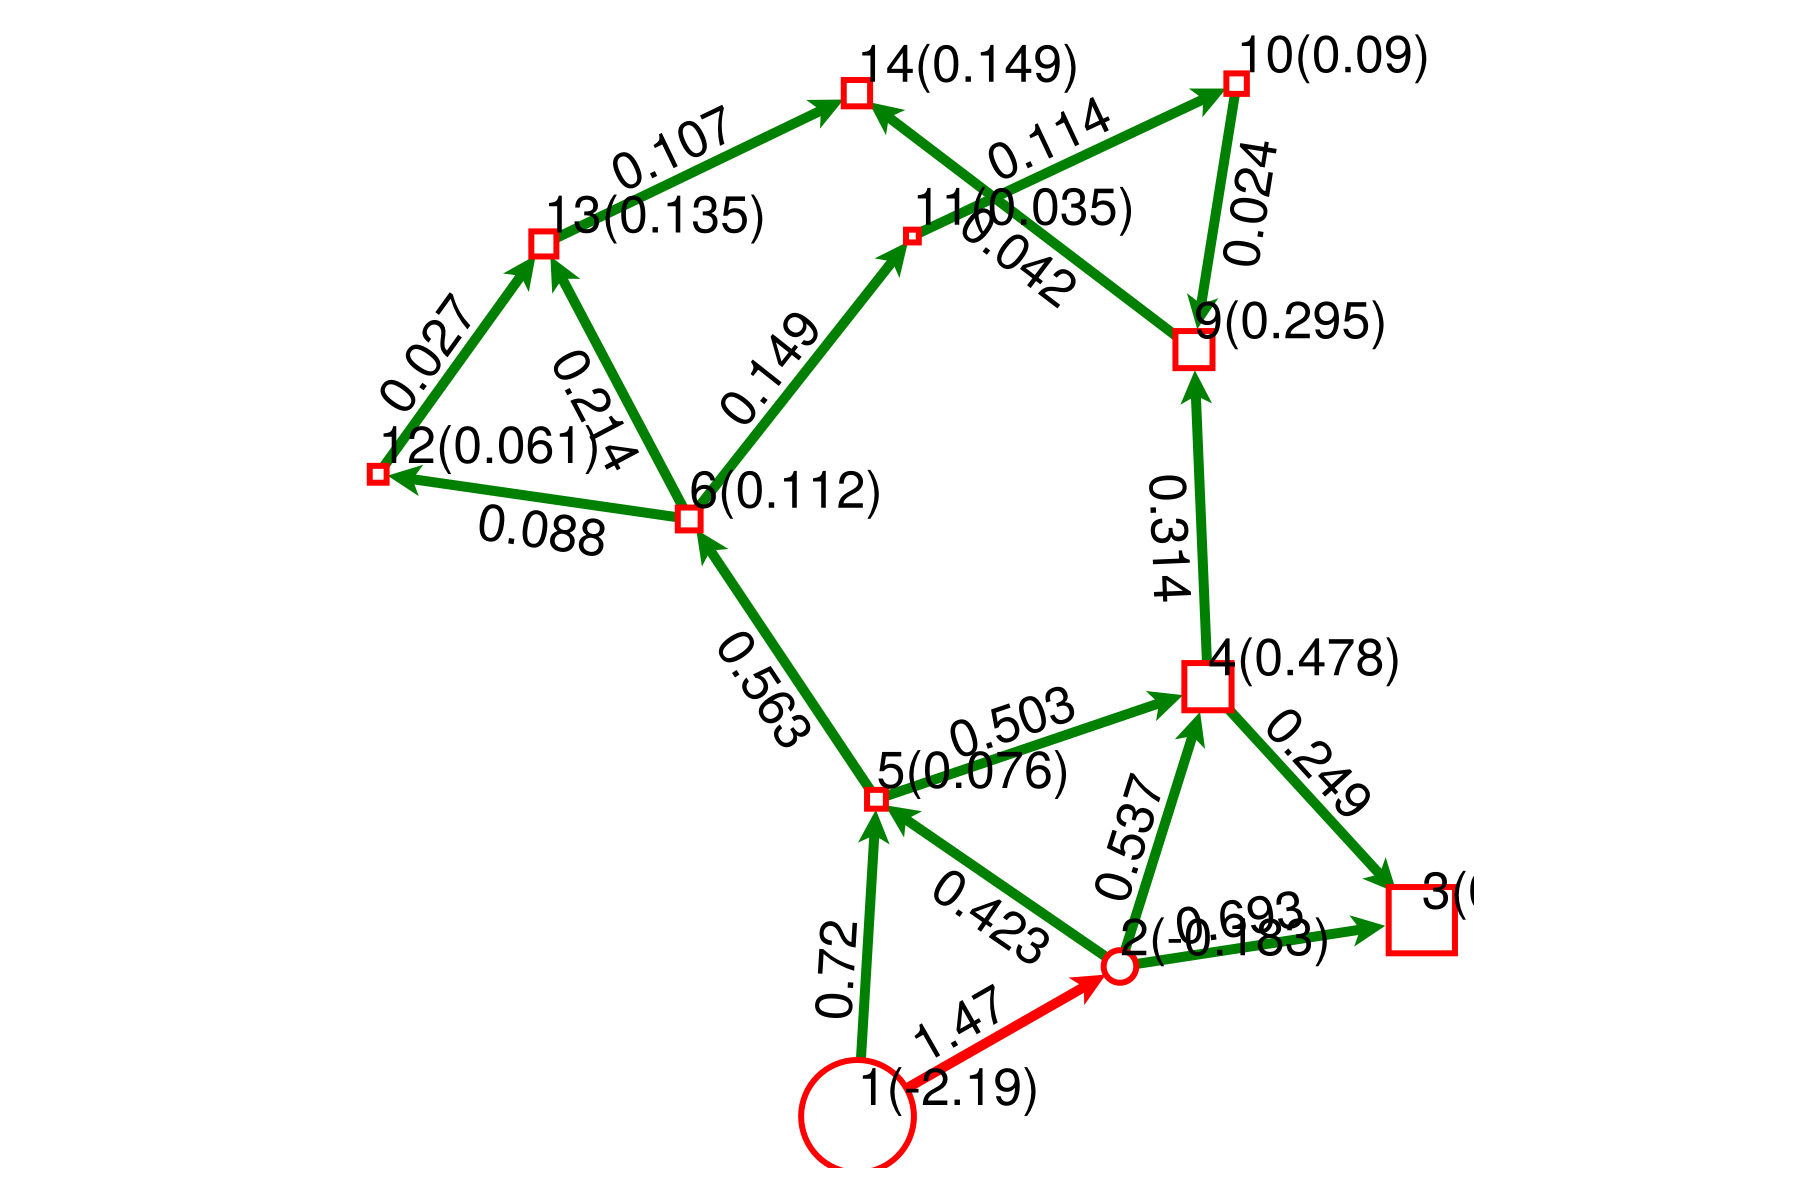

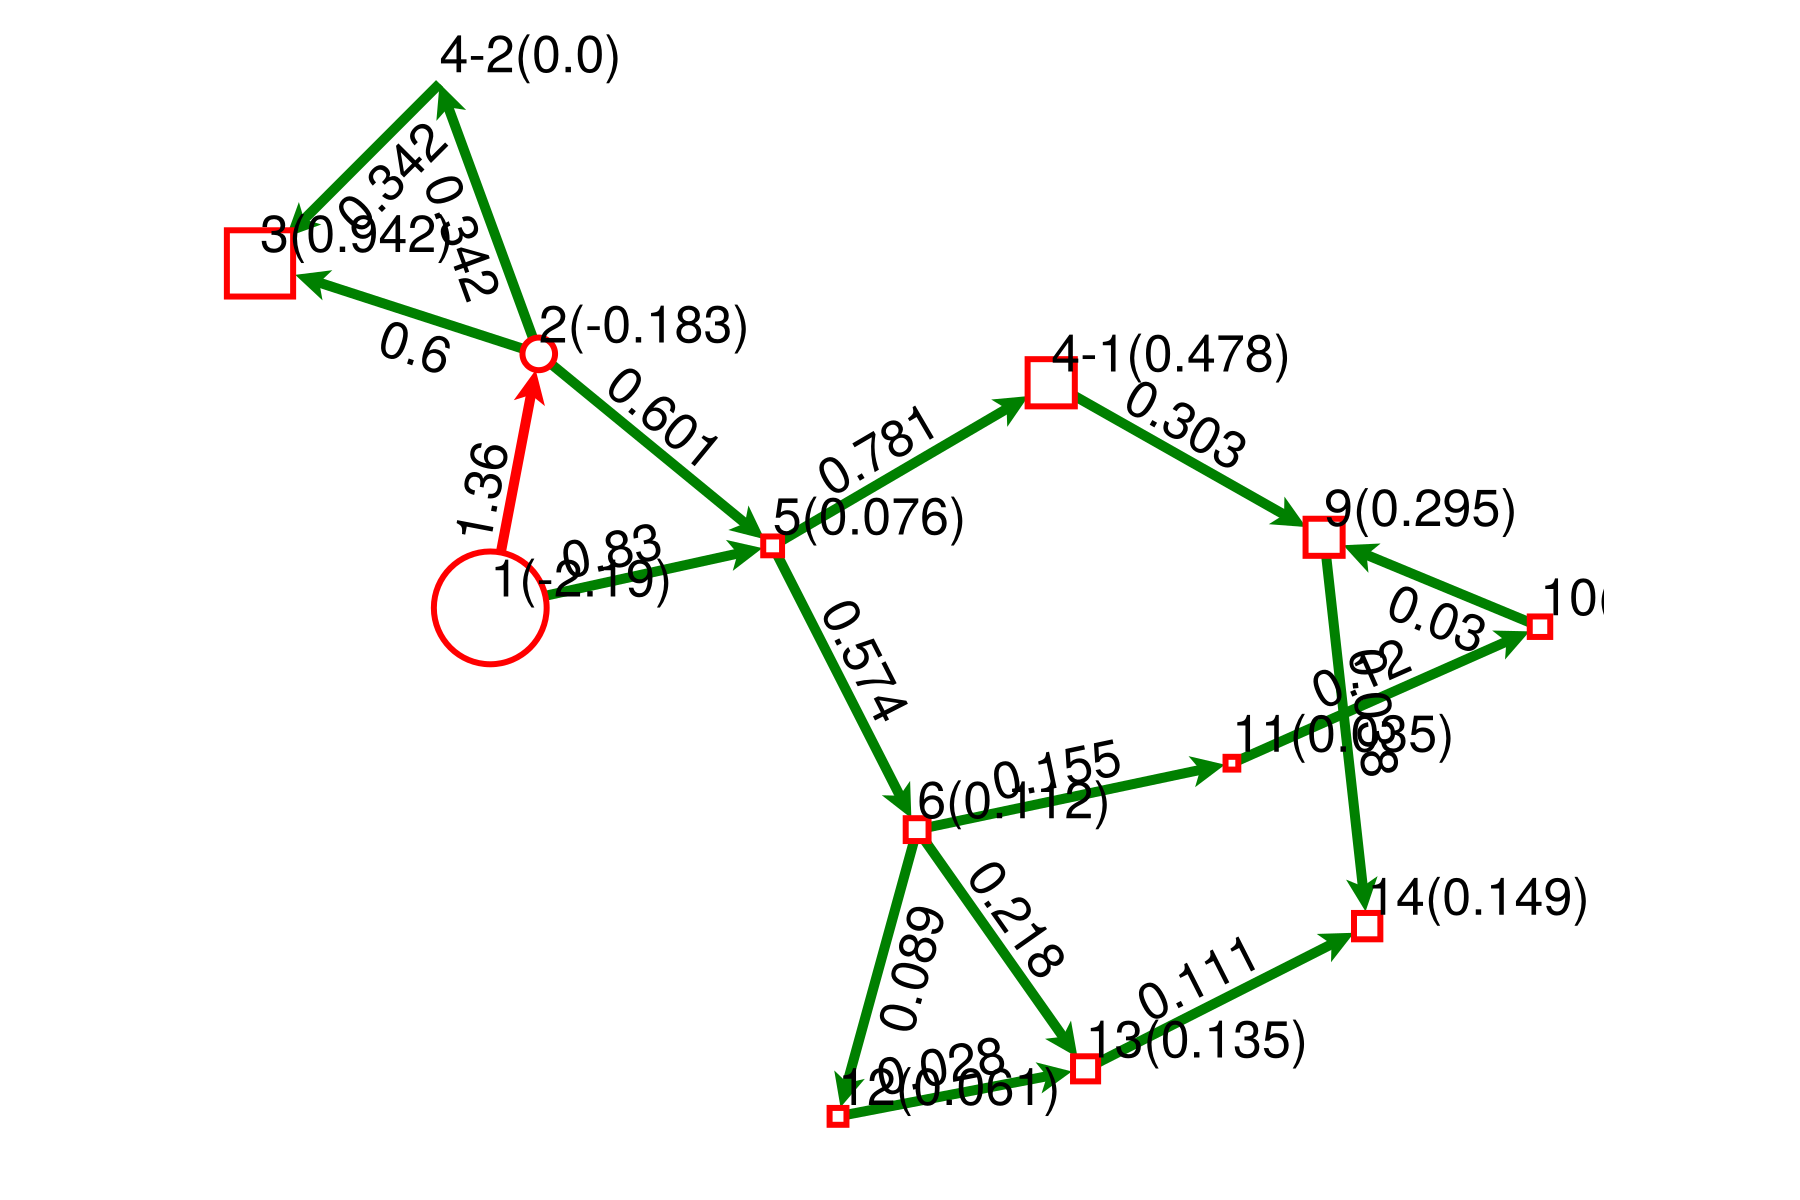

In [380]:
bc = [BusConf(10,
[SubBus(0.478 , [13, 14]),
 SubBus(0    , [9, 12]) ])]
g = create_case()
h = add_subBus(create_case(), bc)
dc_flow!(g)
dc_flow!(h)
draw(g, digits = 3)
draw(h, digits = 3);

In [375]:
check_flow_consistency(g)

false

In [25]:
trip = nothing
outages = [7,13, 14]
dc_flow!(g, outages = outages)
print(maximum(abs.([e_index_for(g,e).p for e in edges(g)])))

1.3171505757251645

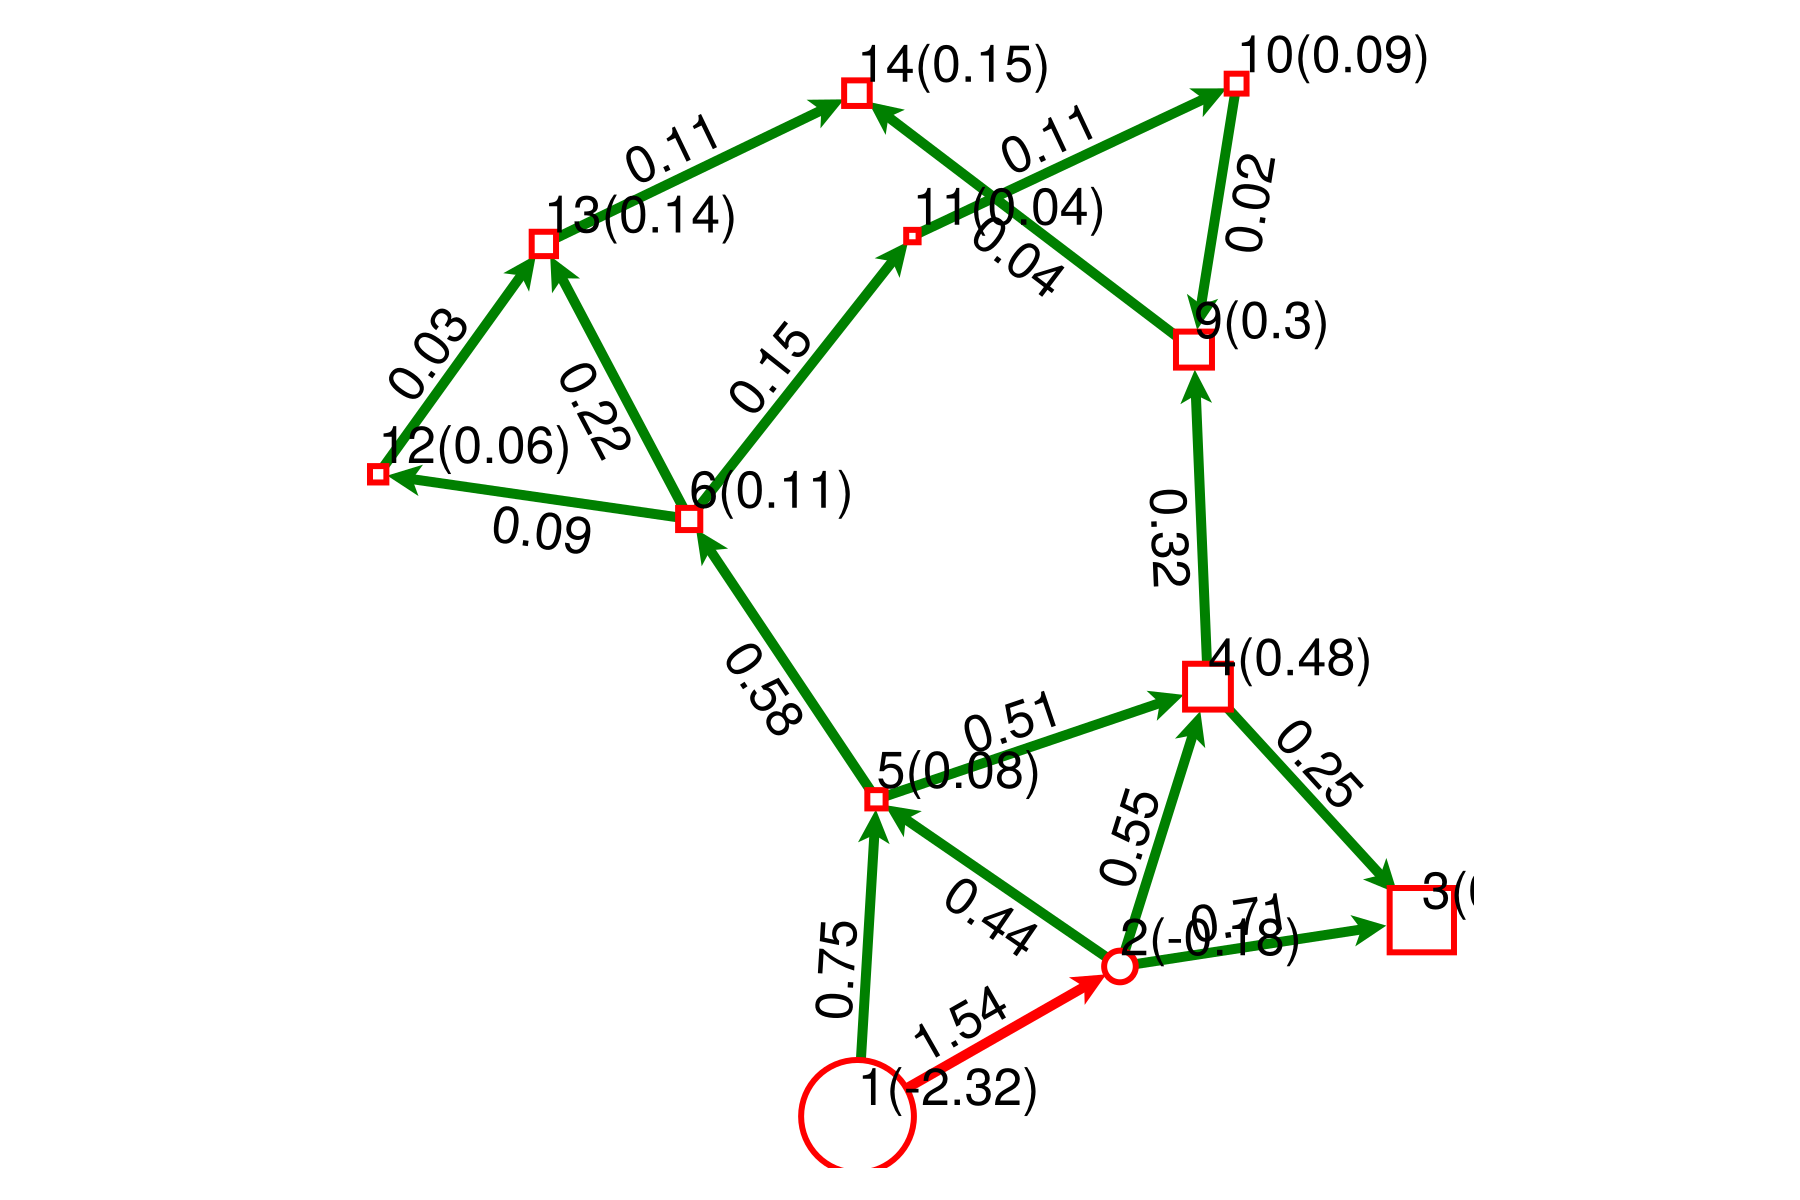

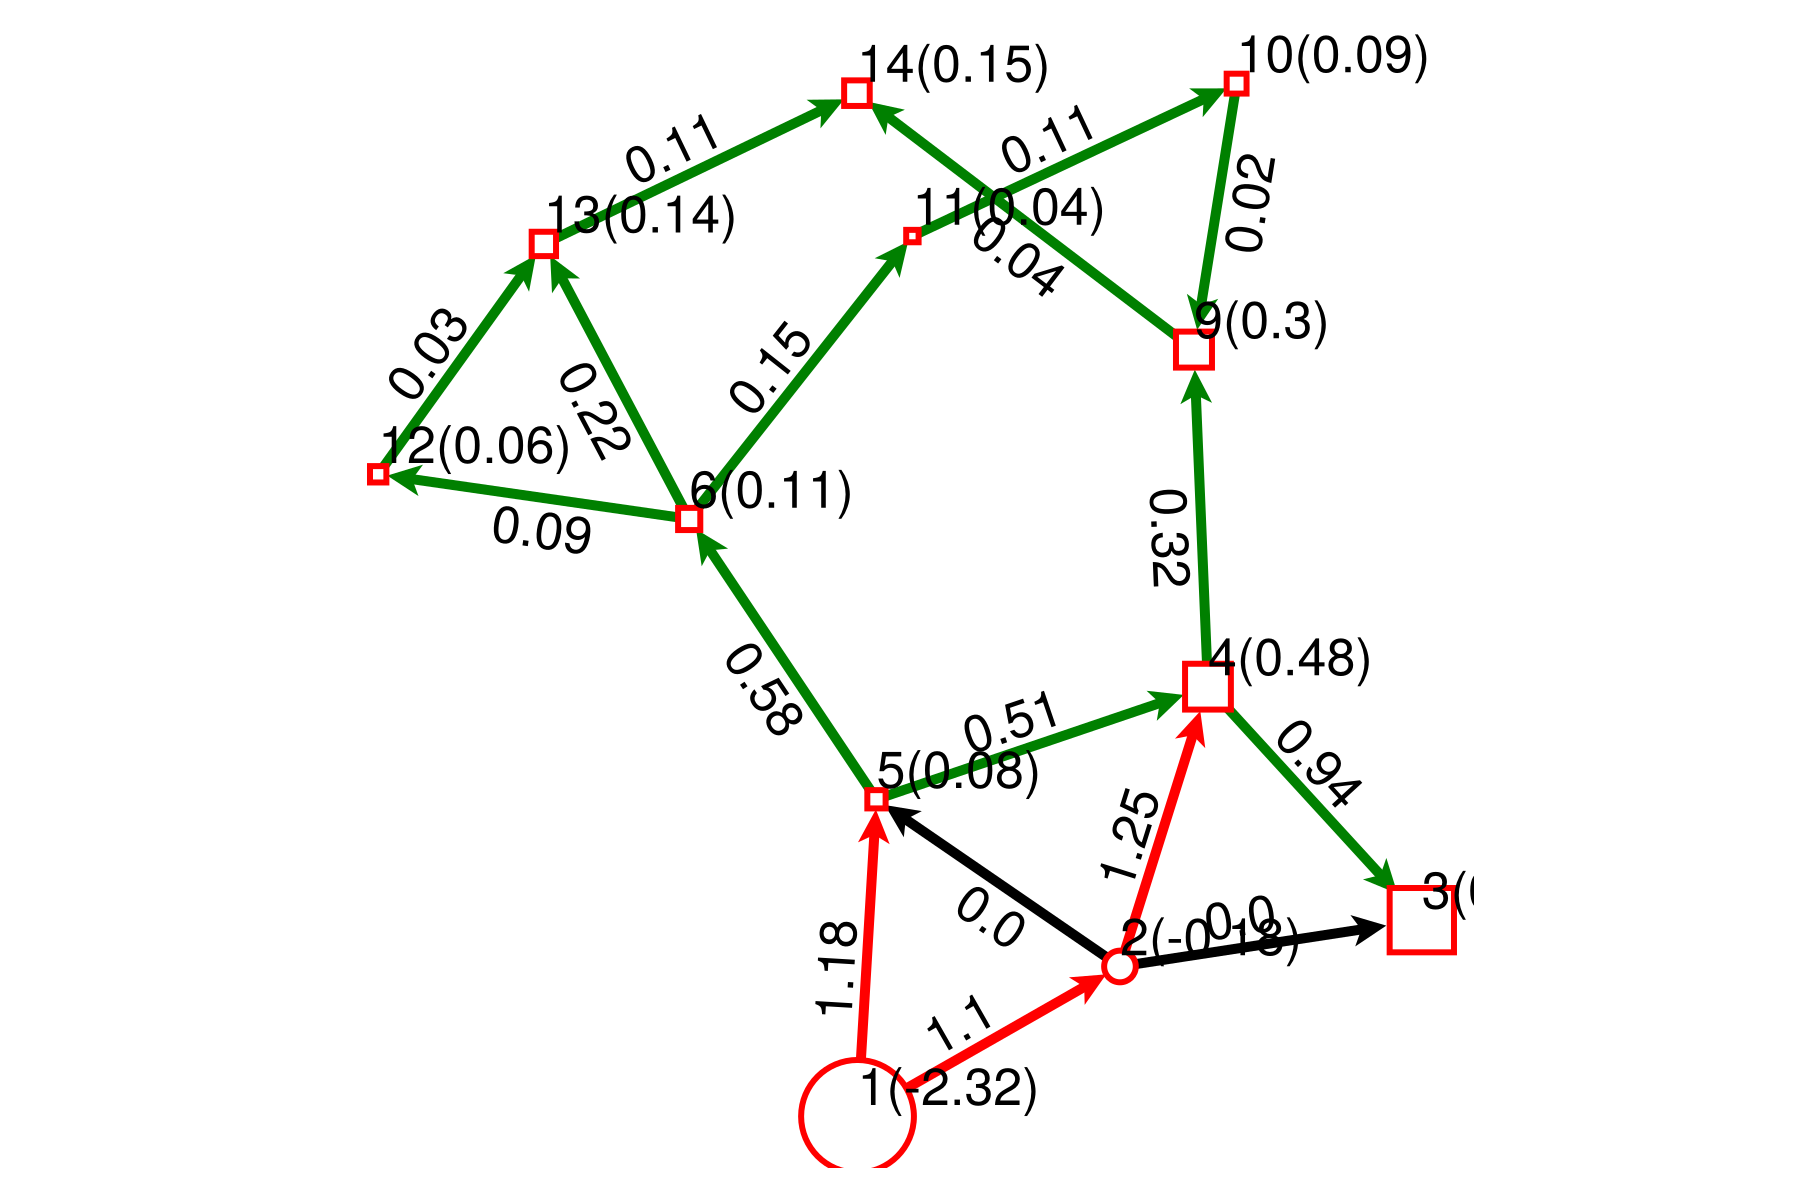

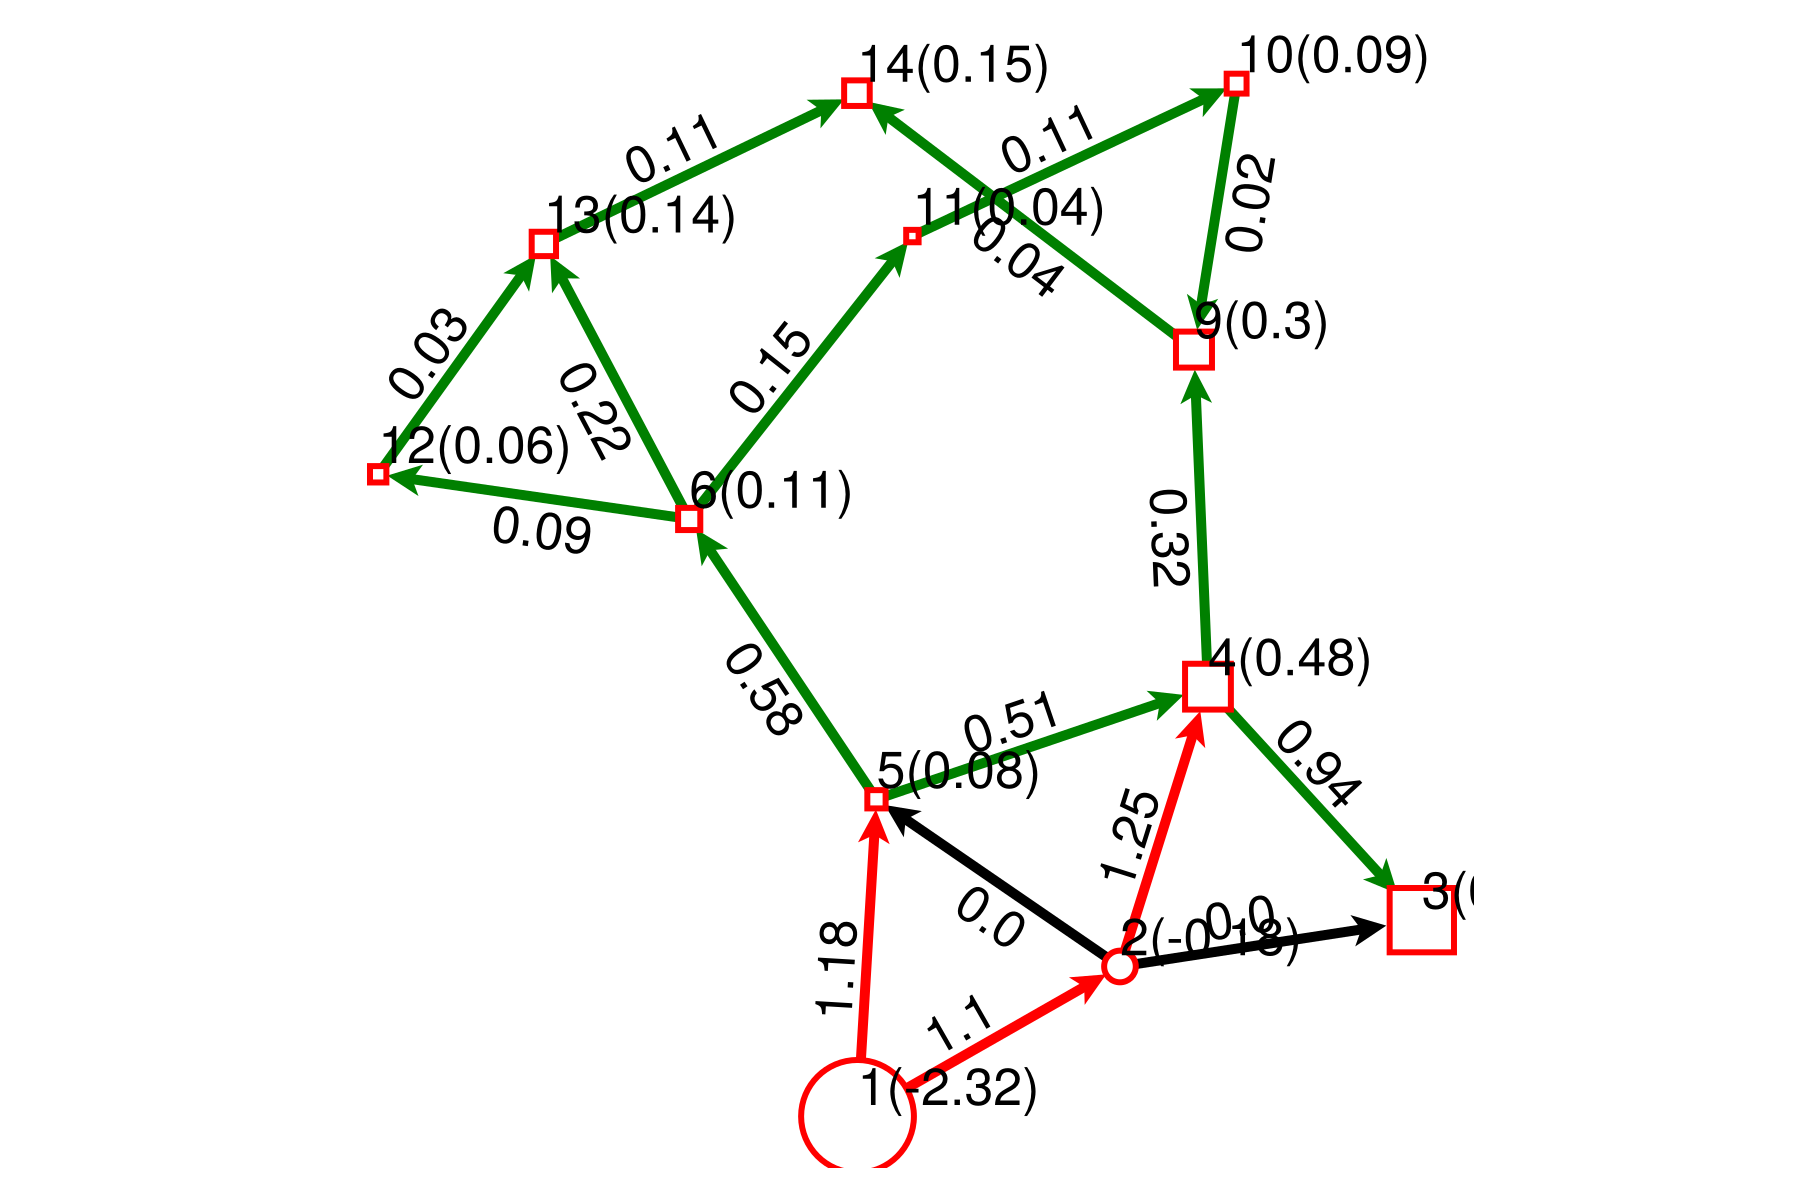

In [219]:
outages=[7, 8]
trip = nothing
dc_flow!(g, trip = trip)
draw(g, trip = trip)#, fig_size = (1300,1300), font_size = 10)
dc_flow!(g, outages = outages)
draw(g, outages = outages)
dc_flow!(g, outages = outages, trip = trip)
draw(g, outages = outages, trip = trip);


## Secured DC PF

$$ \rho^* = \arg\,\max_{\vec{\beta},\vec{u}}\, \min_{\rho}\rho\\
s.t.\\
\vec{f} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})\vec{\beta}\\
|\vec{f}| \preceq \rho \overline{\vec{f}} \\
(1-\vec{u}) \odot \vec{\beta} = 0 \\
u_l \in \{0,1\} \\
\sum_l{u_l} \le 1

$$

$$ \rho^* = \arg\,\max_{\vec{w},\vec{u}, \vec{\beta},\rho}\, \rho \\
s.t. \\
\vec{f} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})\vec{\beta} \\
|\vec{f}| \preceq (1-\vec{u})M \\
|\vec{f} - \rho \overline{\vec{f}}| \preceq (1-\vec{w})M\\
|\vec{\beta}| \preceq \vec{u}M \\
u_l \in \{0,1\} \\
\sum_l{u_l} \le 1
$$

$$
w_l \in \{0,1\} \qquad \forall l \\
\sum_{l}{w_l}=1
$$

In [27]:
function secured_dc_pf_optim_2(g)
    model = Model(() -> Gurobi.Optimizer(env))
    set_silent(model)

    A = incidence_matrix(g; oriented = true)'
    D = spdiagm([e_index_for(g,e).b for e in edges(g)]) #TODO: check consistency
    B = A'*D*A
    B_inv = inv(Matrix(B + spdiagm(fill(1/nv(g), nv(g)))))
    p_to_f = D*A*B_inv
    δ_to_f = D - p_to_f*A'*D
    big_M = 100

    p = [g[label_for(g, v)] for v in vertices(g)]
    p_max = [e_index_for(g, e).p_max for e in edges(g)]
    
    @variable(model, flows[1:ne(g)])
    @variable(model, β[1:ne(g)])
    @variable(model, ρ)
    # @variable(model, 0 ≤ u[i=1:ne(g)] ≤ 1)
    @variable(model, u[1:ne(g)], Bin)
    @variable(model, w[1:ne(g)], Bin)
    # @variable(model, 0 ≤ w[i=1:ne(g)] ≤ 1)
    
    @constraint(model, c_flows , flows == p_to_f * p + δ_to_f * β)

    @constraint(model,  flows ≤ ρ.*p_max)
    @constraint(model, -flows ≤ ρ.*p_max)
    
    @constraint(model,  flows .≤ big_M.*(1 .- u))
    @constraint(model, -flows .≤ big_M.*(1 .- u))
    
    @constraint(model, ρ .- flows .≤ big_M.*(1 .- w))
    @constraint(model, flows .- ρ .≤ big_M.*(1 .- w))

    @constraint(model,  β ≤ big_M .* u)
    @constraint(model, -β ≤ big_M .* u)

    @constraint(model, sum_u, sum(u) == 1)
    @constraint(model, sum_w, sum(w) == 1)

    @objective(model, Max, ρ)
    model
end

secured_dc_pf_optim_2 (generic function with 1 method)

In [28]:
sys = System(joinpath("data", "case118.m"))
# sys = System(joinpath("data", "case1354pegase.m"))
g = network2graph(sys)
add_constraint(g, b->b.p_max=1)

┌ Info: Correcting vm in bus 19 to 0.962 to match generator set-point
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/matpower.jl:242
┌ Info: Correcting vm in bus 32 to 0.963 to match generator set-point
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/matpower.jl:242
┌ Info: Correcting vm in bus 34 to 0.984 to match generator set-point
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/matpower.jl:242
┌ Info: Correcting vm in bus 92 to 0.99 to match generator set-point
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/matpower.jl:242
┌ Info: Correcting vm in bus 103 to 1.01 to match generator set-point
└ @ PowerSystems /Users/benoitjeanson/.julia/packages/PowerSystems/mjN6j/src/parsers/pm_io/matpower.jl:242
┌ Info: this code only supports angmin values in -90 deg. to 90 deg., tightening the value on branch 1 from -360.0 t

In [29]:
model = secured_dc_pf_optim_2(g)
optimize!(model)
# display(latex_formulation(model))
println(value(model[:ρ]))
println(value.(model[:u]))
println(value.(model[:w]))
# println(value.(model[:flows]))
print(solution_summary(model))

5.350251298356511
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

## Secured DC OTS


$$ \rho^* = \arg\,\min_{v, \vec{\gamma}}\,\max_{\vec{\beta},\vec{u}}\rho\\
s.t.\\
\vec{f} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})(\vec{\beta} + \vec{\gamma})\\
|\vec{f}| \preceq \rho \overline{\vec{f}} \\
(1-\vec{u}) \odot \vec{\beta} = 0 \\
(1-\vec{v}) \odot \vec{\gamma} = 0 \\
u_l \in \{0,1\} \\
\sum_l{u_l} \le 1
v_l \in \{0,1\} \qquad \forall l \\
$$

$$ \rho^* = \arg\,\min_{\vec{v}, \vec{\gamma}} \max_{\vec{w},\vec{u}, \vec{\beta},\rho}\, \rho \\
s.t. \\
\vec{f} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})(\vec{\beta} + \vec{\gamma}) \\
|\vec{f}| \preceq (1-\vec{u})M \\
|\vec{f}| \preceq (1-\vec{v})M \\
|\vec{f} - \rho \overline{\vec{f}}| \preceq (1-\vec{w})M\\
|\vec{\beta}| \preceq \vec{u}M \\
|\vec{\gamma}| \preceq \vec{v}M \\
u_l \in \{0,1\} \qquad \forall l \\
\sum_l{u_l} \le 1
$$

$$
w_l \in \{0,1\} \qquad \forall l \\
\sum_{l}{w_l}=1 \\
v_l \in \{0,1\} \qquad \forall l \\
$$

In [30]:
function secured_dc_ots(g)
    model = Model(() -> Gurobi.Optimizer(env))
    set_silent(model)

    A = incidence_matrix(g; oriented = true)'
    D = spdiagm([e_index_for(g,e).b for e in edges(g)]) #TODO: check consistency
    B = A'*D*A
    B_inv = inv(Matrix(B + spdiagm(fill(1/nv(g), nv(g)))))
    p_to_f = D*A*B_inv
    δ_to_f = D - p_to_f*A'*D
    big_M = 100

    p = [g[label_for(g, v)] for v in vertices(g)]
    p_max = [e_index_for(g, e).p_max for e in edges(g)]
    
    @variable(model, flows[1:ne(g)])
    @variable(model, β[1:ne(g)])
    @variable(model, γ[1:ne(g)])
    @variable(model, ρ)
    # @variable(model, 0 ≤ u[i=1:ne(g)] ≤ 1)
    @variable(model, u[1:ne(g)], Bin)
    @variable(model, v[1:ne(g)], Bin)
    @variable(model, w[1:ne(g)], Bin)
    # @variable(model, 0 ≤ w[i=1:ne(g)] ≤ 1)
    
    @constraint(model, c_flows , flows == p_to_f * p + δ_to_f * (β + γ))

    @constraint(model,  flows ≤ ρ.*p_max)
    @constraint(model, -flows ≤ ρ.*p_max)
    
    @constraint(model,  flows .≤ big_M.*(1 .- u))
    @constraint(model, -flows .≤ big_M.*(1 .- u))
    
    @constraint(model,  flows .≤ big_M.*(1 .- v))
    @constraint(model, -flows .≤ big_M.*(1 .- v))
    
    @constraint(model, ρ .- flows .≤ big_M.*(1 .- w))
    @constraint(model, flows .- ρ .≤ big_M.*(1 .- w))

    @constraint(model,  β ≤ big_M .* u)
    @constraint(model, -β ≤ big_M .* u)

    @constraint(model,  γ ≤ big_M .* v)
    @constraint(model, -γ ≤ big_M .* v)

    @constraint(model, sum_u, sum(u) == 1)
    @constraint(model, sum_w, sum(w) == 1)

    @objective(model, Max, ρ)
    model
end

secured_dc_ots (generic function with 1 method)

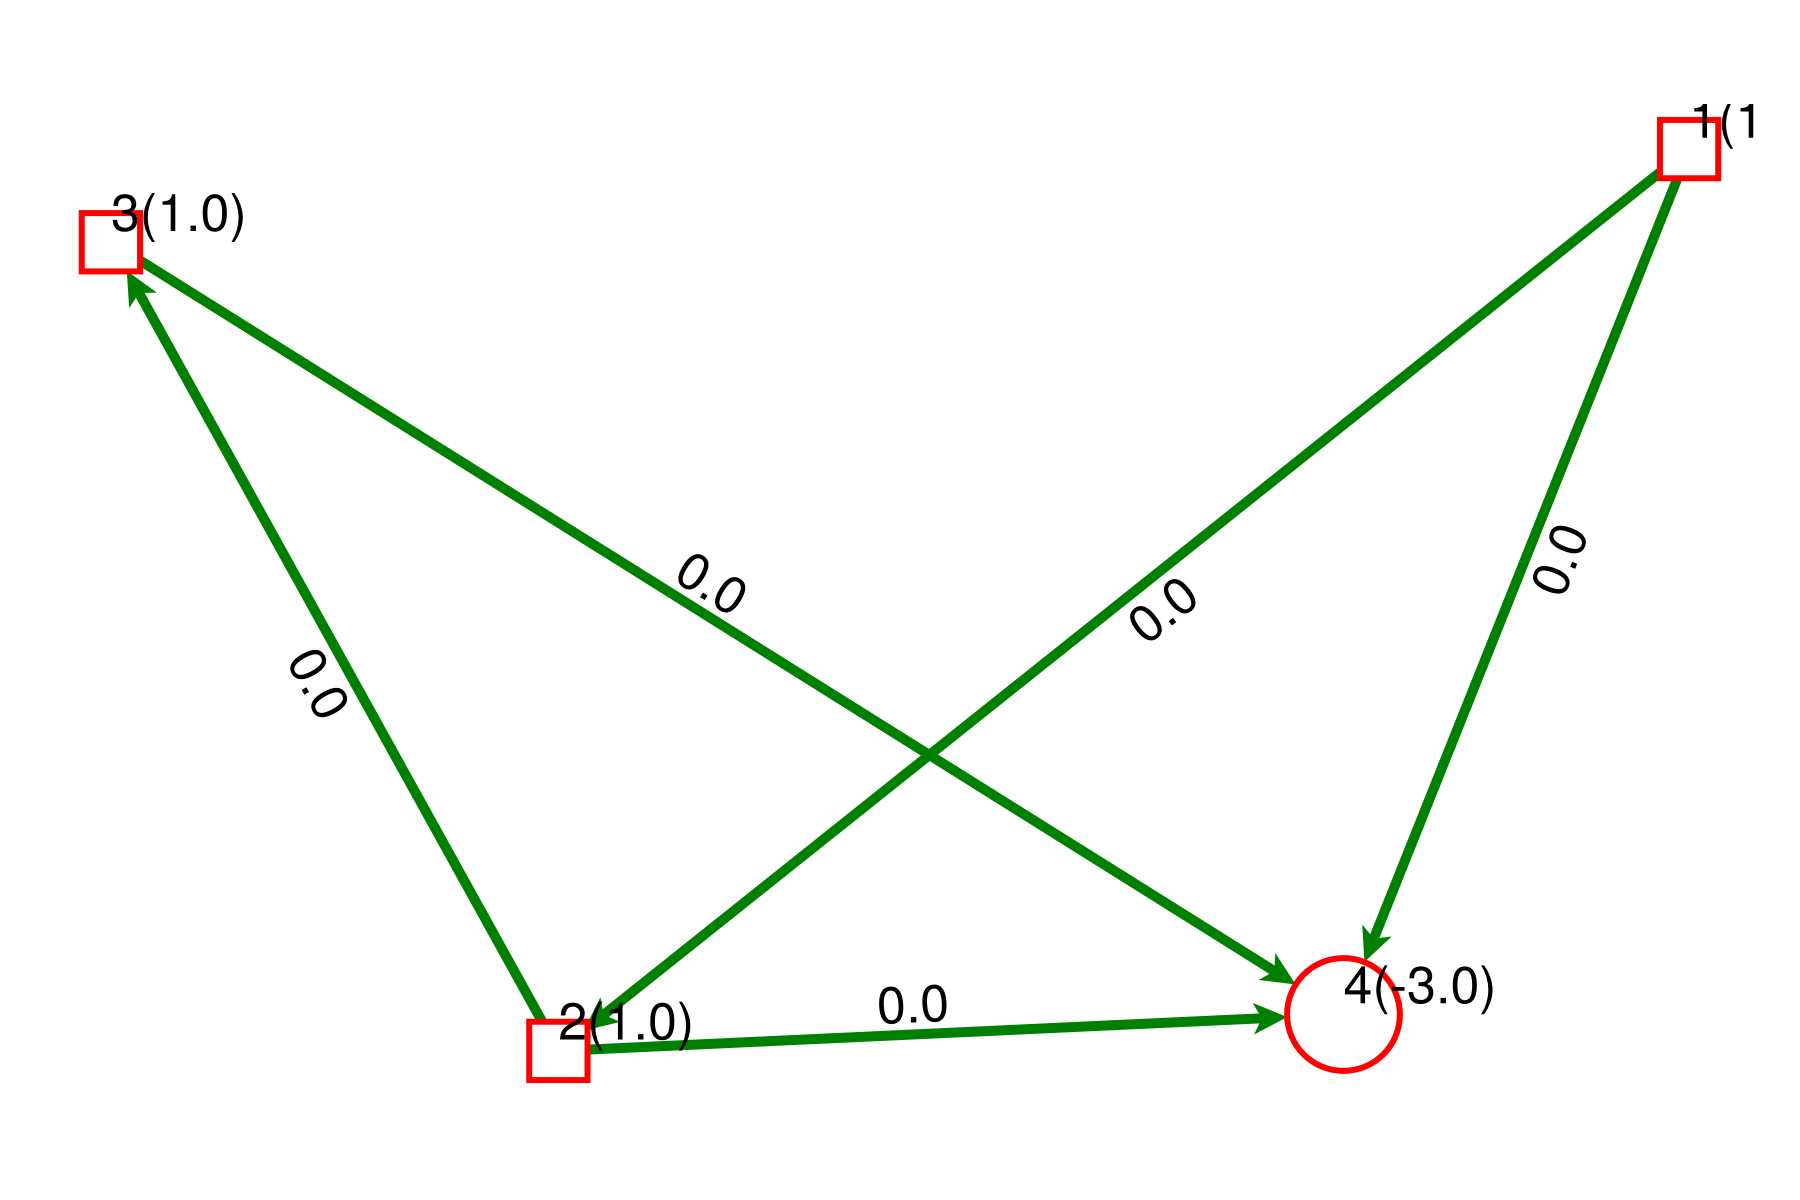

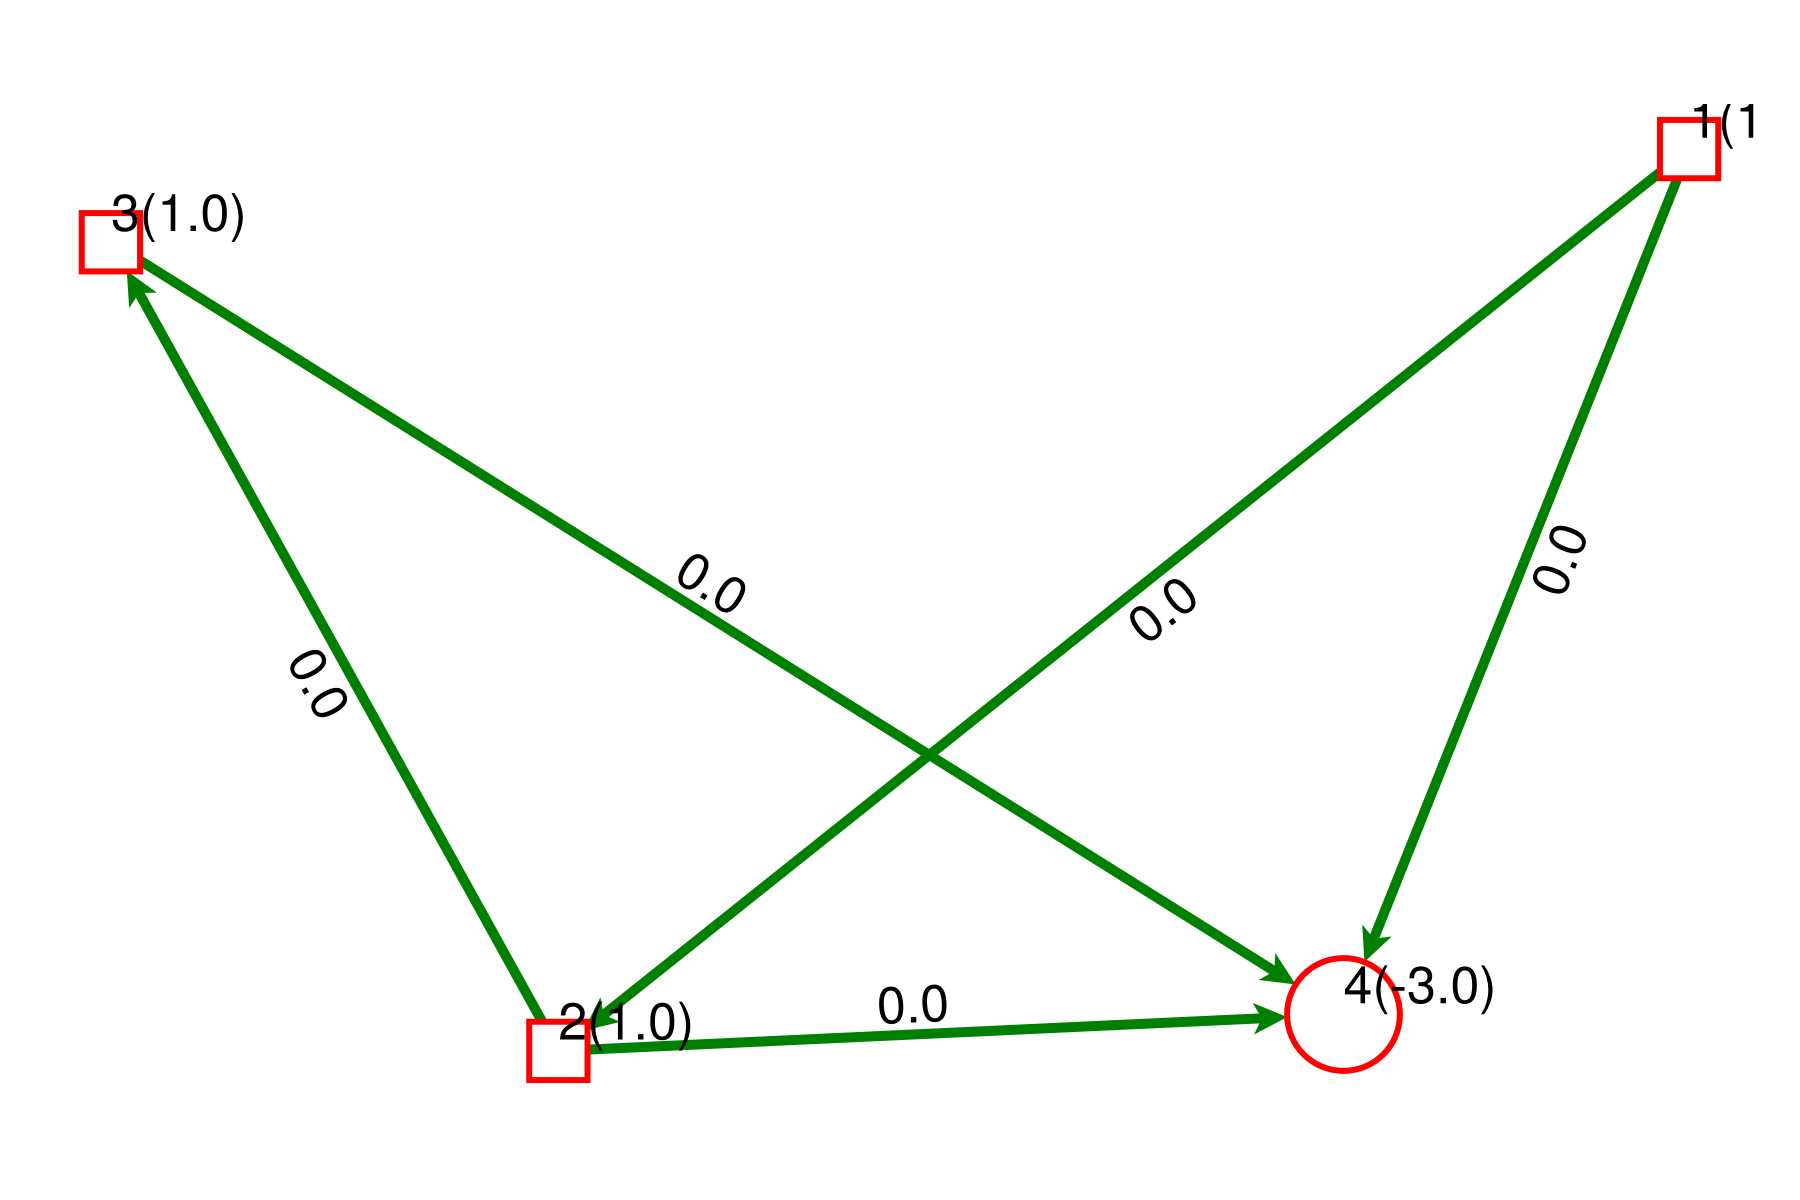

In [31]:
function build_simple_grid()
    g = MetaGraph(
        DiGraph();
        label_type=Int64,
        vertex_data_type = Float64,
        edge_data_type = Branch,
    )
    for i=1:3
        g[i] = 1
    end
    g[4] = -3
    g[1,2] = Branch(1, 1)
    g[2,3] = Branch(1, 1)
    g[3,4] = Branch(1, 1)
    g[2,4] = Branch(1, 1)
    g[1,4] = Branch(1, 1)
    g
end
g = build_simple_grid()
draw(g)


In [32]:
model = secured_dc_ots(g)
# optimize!(model)
display(latex_formulation(model))
# println(value(model[:ρ]))
# println(value.(model[:u]))
# println(value.(model[:w]))
# println(value.(model[:v]))
# println(value.(model[:flows]))
# print(solution_summary(model))

$$ \begin{aligned}
\max\quad & ρ\\
\text{Subject to} \quad & u_{1} + u_{2} + u_{3} + u_{4} + u_{5} = 1\\
 & w_{1} + w_{2} + w_{3} + w_{4} + w_{5} = 1\\
 & flows_{1} + 100 u_{1} \leq 100\\
 & flows_{2} + 100 u_{2} \leq 100\\
 & flows_{3} + 100 u_{3} \leq 100\\
 & flows_{4} + 100 u_{4} \leq 100\\
 & flows_{5} + 100 u_{5} \leq 100\\
 & -flows_{1} + 100 u_{1} \leq 100\\
 & -flows_{2} + 100 u_{2} \leq 100\\
 & -flows_{3} + 100 u_{3} \leq 100\\
 & -flows_{4} + 100 u_{4} \leq 100\\
 & -flows_{5} + 100 u_{5} \leq 100\\
 & flows_{1} + 100 v_{1} \leq 100\\
 & flows_{2} + 100 v_{2} \leq 100\\
 & flows_{3} + 100 v_{3} \leq 100\\
 & flows_{4} + 100 v_{4} \leq 100\\
 & flows_{5} + 100 v_{5} \leq 100\\
 & -flows_{1} + 100 v_{1} \leq 100\\
 & -flows_{2} + 100 v_{2} \leq 100\\
 & -flows_{3} + 100 v_{3} \leq 100\\
 & -flows_{4} + 100 v_{4} \leq 100\\
 & -flows_{5} + 100 v_{5} \leq 100\\
 & -flows_{1} + ρ + 100 w_{1} \leq 100\\
 & -flows_{2} + ρ + 100 w_{2} \leq 100\\
 & -flows_{3} + ρ + 100 w_{3} \leq 1

# Work in progress

$$
\max_{\vec{\beta}, \vec{u}}{\rho} \\
\begin{split}
    \vec{g} = \vec{f} -\mathbf{DA}\mathbf{\hat{B}}^{-1}\vec{p} - (\mathbf{D} -\mathbf{DA}\mathbf{\hat{B}}^{-1}\mathbf{A}^T\mathbf{D})(\vec{\beta} + \mathbf{T}\vec{\gamma}) & \rightarrow \vec{\nu} \\
    \vec{f} - (1-\vec{u})M \preceq 0 & \rightarrow \vec{\lambda_{f pos}}\\
    - \vec{f} - (1-\vec{u})M \preceq 0 & \rightarrow  \vec{\lambda_{f neg}}\\
    \vec{\beta} - \vec{u}M \preceq 0 & \rightarrow  \vec{\lambda_{\beta pos}}\\
    -\vec{\beta} - \vec{u}M \preceq 0 & \rightarrow \vec{\lambda_{\beta neg}}\\
    \vec{u} -1 \preceq 0 \ & \rightarrow \vec{\lambda_{u pos}} \\
    -\vec{u} \preceq 0 \ l & \rightarrow  \vec{\lambda_{u neg}} \\
    -1 + \sum_l{u_l} \le 0 & \rightarrow  \lambda_{u sum}
\end{split}
$$

It is a LP, for which the dual function is known.
$$
\max_{\vec{x}} \vec{c} \odot \vec{x} \\
s.t. \\
\mathbf{A} \vec{x} = \vec{b} \\
\vec{x} \preceq 0
$$

Dual
$$
\min_{\vec{\nu}, \vec{\lambda}} -\vec{b} \odot \vec{x} \\
s.t. \\
\vec{c} + \vec{\lambda} + \mathbf{A}^T\vec{\nu} = 0 \\
\vec{\lambda} \succeq 0
$$




In [301]:
size(D)

(12, 12)

In [348]:
# sys = System(joinpath("data", "case14.m"));
g = network2graph(sys)
add_constraint(g, b->b.p_max=1)
g["1"] = g["1"] + .134
B = dc_flow!(g)


In [359]:
check_flow_consistency(h, v=true)


Comparison with injections:
Node 3: Injection = 0.9420000000000001, Net Flow = 0.9420000000000001, Difference = 0.0
Node 1: Injection = -2.19, Net Flow = -2.189999999999998, Difference = -1.7763568394002505e-15
Node 12: Injection = 0.061, Net Flow = 0.06099999999999969, Difference = 3.0531133177191805e-16
Node 2: Injection = -0.18300000000000002, Net Flow = -0.18300000000000083, Difference = 8.049116928532385e-16
Node 6: Injection = 0.11199999999999999, Net Flow = 0.11200000000000049, Difference = -4.996003610813204e-16
Node 4-1: Injection = 0.478, Net Flow = 0.4780000000000002, Difference = -2.220446049250313e-16
Node 11: Injection = 0.035, Net Flow = 0.03499999999999977, Difference = 2.3592239273284576e-16
Node 13: Injection = 0.135, Net Flow = 0.13499999999999948, Difference = 5.273559366969494e-16
Node 4-2: Injection = 0.0, Net Flow = -2.220446049250313e-16, Difference = 2.220446049250313e-16
Node 5: Injection = 0.076, Net Flow = 0.07599999999999929, Difference = 7.077671781985373

true